# Analysis of the Berka dataset
http://lisp.vse.cz/pkdd99/berka.htm

In [42]:
%pylab inline
import pandas as pd
import pickle
import os
from datetime import date
from scipy import sparse, io

Populating the interactive namespace from numpy and matplotlib


In [43]:
def parse_dataset():
    for filename in os.listdir('original'):
        with open('original/' + filename, 'r') as input_file, open('parsed/' + filename.split('.')[0] + '.csv', 'w') as output_file:
            for line in input_file.readlines():
                print(line.replace('"', '').replace('\n', '').replace(';', ', ').replace(' ', ''), file=output_file)

In [44]:
if not os.path.isdir("parsed"):
    os.mkdir("parsed")
    parse_dataset()

## Transactions
We are interested in the actual transactions, so we'll analyze the trans.csv file

In [45]:
df = pd.read_csv('parsed/trans.csv')
df.head()

/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
0,695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,NaN,NaN,NaN
1,171812,576,930101,PRIJEM,VKLAD,900.0,900.0,NaN,NaN,NaN
2,207264,704,930101,PRIJEM,VKLAD,1000.0,1000.0,NaN,NaN,NaN
3,1117247,3818,930101,PRIJEM,VKLAD,600.0,600.0,NaN,NaN,NaN
4,579373,1972,930102,PRIJEM,VKLAD,400.0,400.0,NaN,NaN,NaN


### Number of transactions per account
We group the accounts and check the number of transactions for each account

In [46]:
df_tc = df.groupby('account_id', as_index=False).size().rename('transaction_count').reset_index()
df_tc['transaction_count'].describe()

count    4500.000000
mean      234.737778
std       126.849443
min         9.000000
25%       133.000000
50%       208.000000
75%       330.000000
max       675.000000
Name: transaction_count, dtype: float64

We have 4500 accounts, with the 25th percentile being at 133 transactions per account. We take only the accounts from the 25th percentile to the 100th

In [49]:
account_id_list = df_tc[df_tc['transaction_count'] >= 133]['account_id'].tolist()
print('75% of transactions are in', len(account_id_list), 'accounts')

75% of transactions are in 3381 accounts


### Dates used
We now check when the starting and ending date of the transactions is

In [51]:
print('Total days with transactions:', len(df[df['account_id'].isin(account_id_list)]['date'].unique()))
min_date = df['date'].min()
max_date = df['date'].max()
print('Start:', min_date)
print('End:', max_date)

Total days with transactions: 2191
Start: 930101
End: 981231


This means that the average 234 transactions are over 2200 days, only the 11% is covered

### Accounts transactions
in the transactions we have both credit(PRIJEM, positive) and withdrawal (VYDAJ, negative)

In [52]:
def split_date(input_date):
    year = 1900 + int(str(input_date)[0:2])
    month = int(str(input_date)[2:4])
    day = int(str(input_date)[4:6])
    return year, month, day

def date_to_index(input_date, starting_date=min_date):
    input_year, input_month, input_day = split_date(input_date)
    starting_year, starting_month, starting_day = split_date(starting_date)

#     delta = date(input_year, input_month, input_day) - date(starting_year, starting_month, starting_day)
    delta = date(input_year, input_month, input_day) - date(1998, 12, 31)
    return delta.days

In [54]:
accounts_to_use = -1 # all accounts
axis = np.arange(0, 500) #NOT ALL ELEMENTS ARE USED, ONLY THE FIRST 500 DAYS

if accounts_to_use != -1:
    account_id_list = account_id_list[:accounts_to_use]
    transactions = np.zeros((accounts_to_use, axis.shape[0]), dtype=np.float32)
else:
    transactions = np.zeros((len(account_id_list), axis.shape[0]), dtype=np.float32)

In [56]:
for account_index, account_id in enumerate(account_id_list):
    if account_index % 100 == 0:
        print(account_index, '/', len(account_id_list))
        
    df_account = df.query('account_id == ' + str(account_id))
    for _, row in df_account.iterrows():
        transaction_date = row['date']
        amount = row['amount']
        if row['type'] == 'VYDAJ':
            amount = -amount
        try:
            transactions[account_index, date_to_index(transaction_date)] = amount
        except:
            pass

transactions = np.delete(transactions, np.where(np.sum(transactions, axis=1) == 0), axis=0)

0 / 3381
100 / 3381
200 / 3381
300 / 3381
400 / 3381
500 / 3381
600 / 3381
700 / 3381
800 / 3381
900 / 3381
1000 / 3381
1100 / 3381
1200 / 3381
1300 / 3381
1400 / 3381
1500 / 3381
1600 / 3381
1700 / 3381
1800 / 3381
1900 / 3381
2000 / 3381
2100 / 3381
2200 / 3381
2300 / 3381
2400 / 3381
2500 / 3381
2600 / 3381
2700 / 3381
2800 / 3381
2900 / 3381
3000 / 3381
3100 / 3381
3200 / 3381
3300 / 3381


Having populated the transactions matrix with the histories for every client, we plot the data

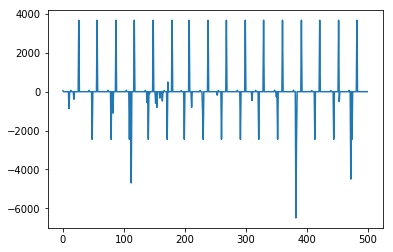

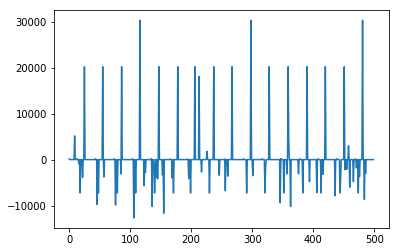

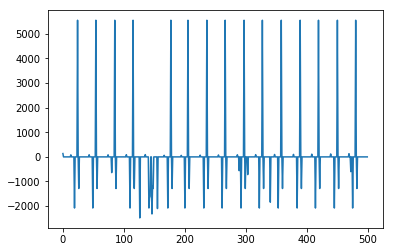

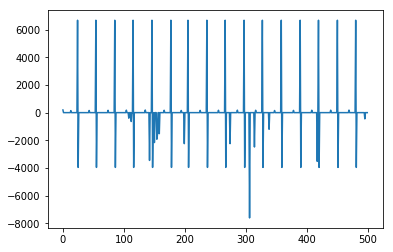

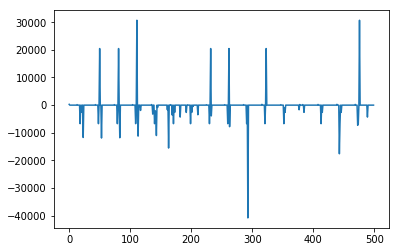

In [57]:
for i in range(5):
    plt.figure()
    plt.plot(transactions[i])

Notice that the values are very high and very sparse. The transactions are converted to a sparse matrix and saved

In [23]:
sparse_transactions = sparse.csr_matrix(transactions)

In [24]:
io.mmwrite('parsed/sparse_transactions_min.mtx', sparse_transactions)

### Analysis of the transactions

In [60]:
sparse_transactions = io.mmread("parsed/sparse_transactions_min.mtx").todense()

In [61]:
print('mean', np.mean(sparse_transactions))
print('min', np.min(sparse_transactions))
print('max', np.max(sparse_transactions))

mean 92.2006341181811
min -87400.0
max 74812.0


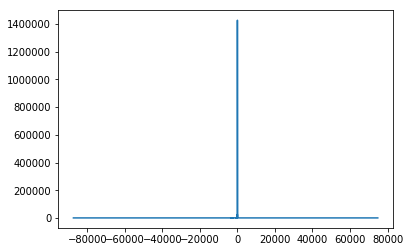

In [67]:
unique_items, counts = np.unique(np.array(sparse_transactions), return_counts=True)
plt.plot(unique_items, counts)

0 is the value that occurs almost everytime

values with highest count: [    0.    -14.6   -30.  -2400.  -1800. ] [1427656   25240    1468    1155    1094]


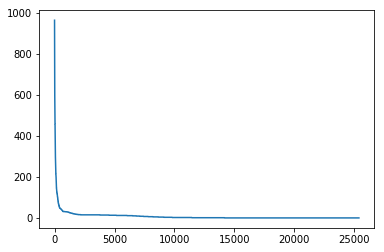

In [79]:
sorted_indexes = np.argsort(-counts)
counts = counts[sorted_indexes]
unique_items = unique_items[sorted_indexes]

print('values with highest count:', unique_items[:5], counts[:5])
plt.plot(counts[5:])

The values still follow a standard Zipf's distribution, but the bad thing is that is extremely heavy tailed

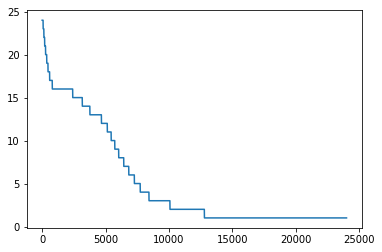

In [93]:
plt.plot(counts[-24000:])

We have around 10k values appearing only once